<a href="https://colab.research.google.com/github/jordan-palmer/ml_bible/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Convolutional Neural Net

Goal: Understand and generate a CNN to come up with an efficient model for the MNIST dataset

Resources: [CNN blog](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/)
____

### Imports (boring)
____

In [11]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
plt.style.use('ggplot')

### Load MNIST dataset
 
What does the input data look like? If you dont know this yourself, how will the machine? ;)
____

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


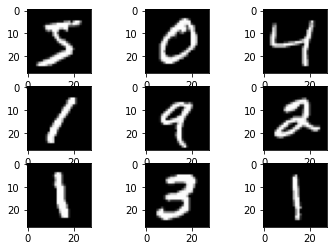

In [2]:
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
### so we have 9 digits, each 28X28 pixels
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

### Load data
There are a total of 10 classes (0 - 9). Use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes `to_categorical`
____

In [3]:
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In grey scale, pixels go from 0 - 255 in value. We want this to be between 0 - 1 --> Normalise!

In [4]:
# scale pixels
def prep_pixels(train, test):
	# normalize to range 0-1
	train_norm = train / 255.0
	test_norm = test / 255.0
	# return normalized images
	return train_norm, test_norm

### Write the CNN
To define the input layer we need to know the filter size, how many filters we wish to use, which activation function, which kernel, and what the input shape is. 
To start, we will use the following:
* **relu activation function**: if the input is > 0, the relu function returns the input, otherwise 0 is returned. "The main reason why ReLu is used is because it is simple, fast, and empirically it seems to work well. Empirically, early papers observed that training a deep network with ReLu tended to converge much more quickly and reliably than training a deep network with sigmoid activation"
* **he_uniform kernel**: It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor
* **Filter size**: (3X3)
* **Number of filters**: 32 (kind of related to the number of features you wish to spot)

The input shape is known and has been determined above

A good resource for trying to understand visually what is going on can be found [here](https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras)

____

In [5]:
# define cnn model
def define_model():
	model = Sequential()
  # kernel initializer describes how we add weights to each kernel. i.e the 3x3 pixel box we move around the 2d image
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  # max pooling. Take the maximum pixel value in the kernel
	model.add(MaxPooling2D((2, 2)))
  # flatten your input to 1D so you can produce a Dense layer (classifier layer). A Dense layer means that all neurons in this layer 
	# grab the information from all neurons in the previous layer.
	model.add(Flatten())
  # dense layer with 100 nodes
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  # dense layer with 10 nodes --> since we have 10 classifications 0 - 9
	# The softmax function is used as the activation function in the output layer of neural network models that predict a multinomial probability distribution
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

### Evaluate the model using **k-fold cross validation**
This process allows us to evaluate the model using different combinations of data for the training and test splitting. This gives us a better idea of how well our model performs

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

How does well does it perform using this current architecture? 

In [7]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)


> 98.608
> 98.625
> 98.567
> 98.775
> 98.775


This is great, on average we see about 98.5% success rate with a very small variance. This also tells us that our model is general enough to work across the entire dataset and there are no anomalous images

Now we should plot our loss and accuracy as a function of epoch and k-fold (for both the training and test data)

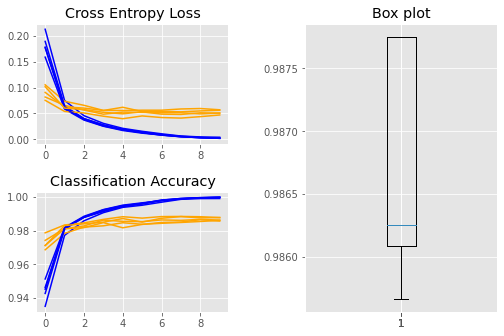

In [36]:
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])
for i in range(len(histories)):
  ax3.title.set_text('Box plot')
  ax3.boxplot(scores)
  ax1.title.set_text('Cross Entropy Loss')
  ax1.plot(histories[i].history['loss'], color='blue', label='train')
  ax1.plot(histories[i].history['val_loss'], color='orange', label='test')
 # plt.subplot(121)
  ax2.title.set_text('Classification Accuracy')
  #ax2.title('Classification Accuracy')
  ax2.plot(histories[i].history['accuracy'], color='blue', label='train')
  ax2.plot(histories[i].history['val_accuracy'], color='orange', label='test')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
# plt.show()

When you see the train and test loss flatten as a function of epoch, this is a good sign that you have selected a good number of epochs as you start to see no improvement. If the loss were to start to increase, this would be a sign of overfitting.




### Can we do better?
Now we can work on improving this model by tweaking the following 

* **Tune Pixel Scaling**. Explore how alternate pixel scaling methods impact model performance as compared to the baseline model, including centering and standardization.
* **Tune the Learning Rate**. Explore how different learning rates impact the model performance as compared to the baseline model, such as 0.001 and 0.0001.
* **Tune Model Depth**. Explore how adding more layers to the model impact the model performance as compared to the baseline model, such as another block of convolutional and pooling layers or another dense layer in the classifier part of the model.